In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import tensorflow as tf

from sklearn.model_selection import train_test_split
from skimage import color, exposure, filters, io, morphology, util
from math import sqrt
from numpy import loadtxt
from tensorflow import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Reshape
from keras.optimizers import SGD

### TRANSFER LEARNING

#### 1.
Bangun sebuah model $\text{Convolutional Neural Network}$ dengan arsitektur dasar sebagai berikut :
- Convolutional Layer ($25$ maps, kernel $3 \times 3$)
- Pooling Layer ($2 \times 2$)
- Activation Function ($\text{ReLU function}$)
- Convolutional Layer ($50$ maps, kernel $3 \times 3$)
- Pooling Layer ($2 \times 2$)
- Activation Function ($\text{ReLU function}$)
- Convolutional Layer ($100$ maps, kernel $3 \times 3$)
- Pooling Layer ($2 \times 2$)
- Activation Function ($\text{ReLU function}$)
- Hidden Layer ($100$ neuron)
- Activation Function ($\text{ReLU function}$)
- Output Layer ($10$ kelas)
- Activation Function ($\text{Softmax function}$)
- Classification Result

Dengan tambahan beberapa seperti:
- Adam optimization
- Early Stop

##### Mendefinisikan Fungsi Bantuan
Untuk memudahkan implementasi, berikut beberapa fungsi bantuan yang akan dipakai

###### Menghitung $\text{recall}$ atau $\text{sensitivity}$
$$\text{recall} = \frac{t_p}{t_p+t_n}$$

In [2]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

###### Menghitung $\text{precision}$
$$\text{precision} = \frac{t_p}{t_p + f_p}$$

In [3]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

###### Menghitung $\text{specificity}$
$$\text{specificity} = \frac{t_n}{t_n + f_p}$$

In [4]:
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

###### Menghitung $f_{1}\text{ Score}$
Kita tau bahwa
$$f_{\beta} = (1 + \beta^{2}) \cdot \frac{\text{precision} \cdot \text{recall}}{(\beta^{2} \cdot \text{precision}) + \text{recall}}$$
Sehingga 
$$f_{1} = (1 + 1^{2}) \cdot \frac{\text{precision} \cdot \text{recall}}{(1^{2} \cdot \text{precision}) + \text{recall}}$$
$$f_{1} = (2) \cdot \frac{\text{precision} \cdot \text{recall}}{(\text{precision}) + \text{recall}}$$



In [5]:
def f1_score(y_true, y_pred):
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2*((precision_val * recall_val)/(precision_val + recall_val + K.epsilon()))

**n.b.: Semua fungsi pada bagian penyebut ditambah epsilon untuk menghindari dibagi $0$ dikarenakan memasukkan input sebanyak $0$**

###### Fungsi Bantuan untuk Melakukan Prediksi dan Menampilkan Metric

In [6]:
def predict_and_get_metrics(model, x_test, y_test, label):
    _, accuracy, sensitivity, specificity, score_f1 = model.evaluate(x_test, y_test, verbose=0)
    return pd.DataFrame([[accuracy, sensitivity, specificity, score_f1]], columns=['Accuracy', 'Sensitivity', 'Specificity', 'F1 Score'], index=[label])

def compare_train_and_test(model, x_train, y_train, x_test, y_test, extra_label=''):
    metric_train = predict_and_get_metrics(model, x_train, y_train, 'Data Train %s' % (extra_label))
    metric_test = predict_and_get_metrics(model, x_test, y_test, 'Data Test %s' % (extra_label))
    return pd.concat([metric_train, metric_test])

###### Fungsi Bantuan untuk _Load Dataset_

In [58]:
def load_dataset_cifar10():
	(trainX, trainY), (testX, testY) = keras.datasets.cifar10.load_data()
	return np.concatenate((trainX, testX), axis=0), np.concatenate((trainY, testY), axis=0)
 
def load_dataset_cifar100():
	(trainX, trainY), (testX, testY) = keras.datasets.cifar100.load_data()
	return np.concatenate((trainX, testX), axis=0), np.concatenate((trainY, testY), axis=0)

##### Load Dataset

In [8]:
x, y = load_dataset_cifar10()
x.shape

170500096/170498071 [==============================] - 2s 0us/step


(60000, 32, 32, 3)

##### Mengambil Dataset Sebanyak 1000 Per Kelasnya

In [9]:
idx_sample = np.array([],dtype=int)

for i in range(10):
    idx = (y == i).reshape(x.shape[0])
    idx_data = np.where(idx == True)
    sampled_list = np.random.choice(idx_data[0], size=1000, replace=False)
    idx_sample = np.concatenate((idx_sample, sampled_list), axis=0)

##### Melakukan Validasi Apakah Shape-nya Sudah Valid atau Belum

In [10]:
x_sample = x[idx_sample]
y_sample = y[idx_sample]
x_sample.shape, y_sample.shape

((10000, 32, 32, 3), (10000, 1))

##### Melakukan Normalisasi untuk $x$

In [11]:
def normalize(x):
    return x / 255.0

x_sample = normalize(x_sample)

##### Merubah Menjadi Matrix Binary untuk $y$

In [12]:
y_sample = tf.keras.utils.to_categorical(y_sample)

##### Memecah Menjadi 60 : 40 ~ Train : Test

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_sample, y_sample, test_size=0.4)

##### Membangun Model Convolutional Neural Network

In [88]:
def create_model(learning_rate, pre_defined_layers=[]):
    convolutional_layers = []
    if len(pre_defined_layers) == 0:
        ## Convolutional Layers 25 map, 3 x 3, activation = relu
        convolutional_layers.append(Conv2D(25, kernel_size=(3, 3), activation=tf.nn.relu, padding='SAME', kernel_initializer=tf.keras.initializers.HeUniform()))

        ## Pooling Layer 2 x 2
        convolutional_layers.append(MaxPooling2D(2,2))

        ## Convolutional Layers 50 map, 3 x 3, activation = relu
        convolutional_layers.append(Conv2D(50, kernel_size=(3, 3), activation=tf.nn.relu, padding='SAME', kernel_initializer=tf.keras.initializers.HeUniform()))

        ## Pooling Layer 2 x 2
        convolutional_layers.append(MaxPooling2D(2,2))

        ## Convolutional Layers 100 map, 3 x 3, activation = relu
        convolutional_layers.append(Conv2D(100, kernel_size=(3, 3), activation=tf.nn.relu, padding='SAME', kernel_initializer=tf.keras.initializers.HeUniform()))

        ## Pooling Layer 2 x 2
        convolutional_layers.append(MaxPooling2D(2,2))

        convolutional_layers.append(Flatten())

        ## Hidden Layer 100 node
        convolutional_layers.append(Dense(100, activation=tf.nn.relu))

        ## Output 10 class
        convolutional_layers.append(Dense(10, activation=tf.nn.softmax))
    else:
        convolutional_layers = pre_defined_layers

    ## Menginisialisasi instance model
    convolutional_model = Sequential(convolutional_layers)

    ## Membangun model
    convolutional_model.build(input_shape=x_train.shape)

    ## Melakukan Kompilasi ke dalam Model
    convolutional_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=[
      'accuracy',
      recall,
      specificity,
      f1_score
    ])

    return convolutional_model

##### Melakukan _fitting_ dengan $\text{epochs} = 100$, $\text{batch_size} = 10$, dan $\text{learning_rate} = 0.1$, dan $\text{Early Stopping}$

In [37]:
## Mendefinisikan Patience Early Stopping untuk Semua Model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [38]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=10, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
600/600 [==============================] - 16s 26ms/step - loss: 14.0499 - accuracy: 0.1048 - recall: 6.6667e-04 - specificity: 0.9993 - f1_score: 6.6667e-04 - val_loss: 2.3311 - val_accuracy: 0.0995 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
600/600 [==============================] - 16s 26ms/step - loss: 2.3290 - accuracy: 0.0900 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3106 - val_accuracy: 0.1072 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/100
600/600 [==============================] - 15s 26ms/step - loss: 2.3247 - accuracy: 0.0988 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3112 - val_accuracy: 0.0978 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 4/100
600/600 [==============================] - 15s 26ms/step - loss: 2.3255 - accuracy: 0.1027 - recall: 0.0000e+00 - specif

#### 3.
Lakukan skenario eksperimen untuk mendapatkan metrik evaluasi optimal ($\text{akurasi}$, $\text{sensitivity}$, $\text{specifity}$, dan $f_{1} \text{ score}$) dengan mengubah parameter yaitu:
1. Mengubah epoch, dengan $\text{learning_rate} = 0.1$ dan $\text
{batch_number} = 10$.
2. Mengubah jumlah $\text{batch number}$ dengan $\text{epoch}$ optimal dari skenario (1) dan $\text{learning_rate} = 0.1$.
3. Mengubah $\text{learning_rate}$ dengan $\text{epoch}$ optimal dari skenario (1) dan jumlah $\text{batch_number}$ optimal dari skenario (2).

##### Melakukan Skenario 3.1. (Mengubah $\text{epoch}$)

###### Skenario 3.1.1. ($\text{epoch} = 50$)

In [39]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=50, batch_size=10, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/50
600/600 [==============================] - 15s 26ms/step - loss: 23.7568 - accuracy: 0.1007 - recall: 1.6667e-04 - specificity: 0.9995 - f1_score: 1.6667e-04 - val_loss: 2.3161 - val_accuracy: 0.0925 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/50
600/600 [==============================] - 15s 25ms/step - loss: 2.3279 - accuracy: 0.0932 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3309 - val_accuracy: 0.1010 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/50
600/600 [==============================] - 15s 25ms/step - loss: 2.3282 - accuracy: 0.0975 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3140 - val_accuracy: 0.0997 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 4/50
600/600 [==============================] - 15s 25ms/step - loss: 2.3264 - accuracy: 0.1033 - recall: 0.0000e+00 - specificit

###### Skenario 3.1.2. ($\text{epoch}$ = 25)

In [40]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=25, batch_size=10, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/25
600/600 [==============================] - 16s 26ms/step - loss: 47.9813 - accuracy: 0.0995 - recall: 0.0012 - specificity: 0.9990 - f1_score: 0.0012 - val_loss: 2.3100 - val_accuracy: 0.0962 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/25
600/600 [==============================] - 16s 26ms/step - loss: 2.3260 - accuracy: 0.1020 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3245 - val_accuracy: 0.0997 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/25
600/600 [==============================] - 16s 26ms/step - loss: 2.3301 - accuracy: 0.0998 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3261 - val_accuracy: 0.0925 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 4/25
600/600 [==============================] - 16s 27ms/step - loss: 2.3253 - accuracy: 0.1008 - recall: 0.0000e+00 - specificity: 1.000

###### Skenario 3.1.3. ($\text{epoch}$ = 10)

In [41]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=10, batch_size=10, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/10
600/600 [==============================] - 16s 26ms/step - loss: 19.2034 - accuracy: 0.1017 - recall: 0.0010 - specificity: 0.9990 - f1_score: 1.0000e-03 - val_loss: 2.3195 - val_accuracy: 0.1010 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/10
600/600 [==============================] - 16s 26ms/step - loss: 2.3262 - accuracy: 0.1000 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3233 - val_accuracy: 0.1060 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/10
600/600 [==============================] - 16s 26ms/step - loss: 2.3246 - accuracy: 0.1043 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3209 - val_accuracy: 0.0995 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 4/10
600/600 [==============================] - 19s 32ms/step - loss: 2.3265 - accuracy: 0.0985 - recall: 0.0000e+00 - specificity: 1

###### Kesimpulan Skenario $3.1.$

Berdasarkan hasil dari skenario $3.1.1$, $3.1.2$, dan $3.1.3$, ketiga skenario mengalami _early stop_ pada $\text{epoch} \leq 4$. Dengan demikian epoch optimal dari skenario-skenario tersebut adalah $\text{epoch}$ dari skenario $3.1.3$, yaitu $10$.

##### Melakukan Skenario $3.2.$ (Mengubah $\text{batch_number}$)

###### Skenario $3.2.1.$ ($\text{batch_number} = 25$)

In [42]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=10, batch_size=25, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/10
240/240 [==============================] - 13s 55ms/step - loss: 75.2109 - accuracy: 0.1035 - recall: 6.6667e-04 - specificity: 0.9987 - f1_score: 6.6667e-04 - val_loss: 2.3079 - val_accuracy: 0.0995 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/10
240/240 [==============================] - 13s 53ms/step - loss: 2.3153 - accuracy: 0.1017 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3203 - val_accuracy: 0.0925 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/10
240/240 [==============================] - 13s 53ms/step - loss: 2.3169 - accuracy: 0.0955 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3095 - val_accuracy: 0.1060 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 4/10
240/240 [==============================] - 13s 55ms/step - loss: 2.3152 - accuracy: 0.0990 - recall: 0.0000e+00 - specificit

###### Skenario $3.2.2.$ ($\text{batch_number} = 50$)

In [43]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=10, batch_size=50, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/10
120/120 [==============================] - 12s 103ms/step - loss: 107.1958 - accuracy: 0.0977 - recall: 0.0020 - specificity: 0.9984 - f1_score: 0.0020 - val_loss: 2.3134 - val_accuracy: 0.0925 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/10
120/120 [==============================] - 12s 100ms/step - loss: 2.3101 - accuracy: 0.0985 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3138 - val_accuracy: 0.1000 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/10
120/120 [==============================] - 12s 101ms/step - loss: 2.3156 - accuracy: 0.0985 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3151 - val_accuracy: 0.0962 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 4/10
120/120 [==============================] - 12s 101ms/step - loss: 2.3133 - accuracy: 0.0997 - recall: 0.0000e+00 - specificity: 

###### Skenario $3.2.3.$ ($\text{batch_number} = 100$)

In [44]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=10, batch_size=100, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/10
60/60 [==============================] - 12s 194ms/step - loss: 73.7438 - accuracy: 0.0953 - recall: 0.0048 - specificity: 0.9967 - f1_score: 0.0048 - val_loss: 2.3090 - val_accuracy: 0.0925 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/10
60/60 [==============================] - 11s 189ms/step - loss: 2.3088 - accuracy: 0.1013 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3090 - val_accuracy: 0.0978 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/10
60/60 [==============================] - 11s 189ms/step - loss: 2.3070 - accuracy: 0.1020 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3080 - val_accuracy: 0.0962 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 4/10
60/60 [==============================] - 11s 189ms/step - loss: 2.3071 - accuracy: 0.0915 - recall: 0.0000e+00 - specificity: 1.0000 - 

###### Skenario $3.2.4.$ ($\text{batch_number} = 500$)

In [45]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=10, batch_size=500, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/10
12/12 [==============================] - 10s 855ms/step - loss: 951.1484 - accuracy: 0.0975 - recall: 0.0327 - specificity: 0.9683 - f1_score: 0.0336 - val_loss: 2.3263 - val_accuracy: 0.0962 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/10
12/12 [==============================] - 10s 829ms/step - loss: 2.3139 - accuracy: 0.1002 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3116 - val_accuracy: 0.0995 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/10
12/12 [==============================] - 10s 833ms/step - loss: 2.3078 - accuracy: 0.1010 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3067 - val_accuracy: 0.1000 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 4/10
12/12 [==============================] - 10s 833ms/step - loss: 2.3057 - accuracy: 0.0998 - recall: 0.0000e+00 - specificity: 1.0000 -

###### Skenario $3.2.5.$ ($\text{batch_number} = 1000$)

In [46]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=10, batch_size=1000, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/10
6/6 [==============================] - 10s 2s/step - loss: 2151.9358 - accuracy: 0.1013 - recall: 0.0403 - specificity: 0.9588 - f1_score: 0.0435 - val_loss: 2.3477 - val_accuracy: 0.0997 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/10
6/6 [==============================] - 9s 2s/step - loss: 2.3250 - accuracy: 0.0973 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3141 - val_accuracy: 0.1072 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/10
6/6 [==============================] - 13s 2s/step - loss: 2.3083 - accuracy: 0.1030 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3082 - val_accuracy: 0.1000 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 4/10
6/6 [==============================] - 9s 2s/step - loss: 2.3085 - accuracy: 0.1022 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00

###### Kesimpulan Skenario $3.2.$

Berdasarkan hasil dari skenario $3.2.1$, $3.2.2$, $3.2.3$, $3.2.4$, dan $3.2.5$, kelima skenario mengalami _early stop_ pada $\text{epoch} \leq 4$. Dengan demikian $\text{batch_size}$ optimal dari skenario-skenario tersebut adalah $\text{batch_size}$ dari skenario $3.2.1$, yaitu $25$.

##### Melakukan Skenario $3.3.$ (Mengubah $\text{learning_rate}$)

###### Skenario $3.3.1.$ ($\text{learning_rate} = 0.25$)

In [47]:
convolutional_model = create_model(0.25)
convolutional_model.fit(x_train, y_train, epochs=10, batch_size=25, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/10
240/240 [==============================] - 13s 55ms/step - loss: 1437.2496 - accuracy: 0.0953 - recall: 0.0015 - specificity: 0.9991 - f1_score: 0.0017 - val_loss: 2.3564 - val_accuracy: 0.0962 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/10
240/240 [==============================] - 13s 54ms/step - loss: 2.3363 - accuracy: 0.1003 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3651 - val_accuracy: 0.1000 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/10
240/240 [==============================] - 13s 54ms/step - loss: 2.3391 - accuracy: 0.0943 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3747 - val_accuracy: 0.0925 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 4/10
240/240 [==============================] - 13s 54ms/step - loss: 2.3460 - accuracy: 0.1022 - recall: 0.0000e+00 - specificity: 1.0

###### Skenario $3.3.2.$ ($\text{learning_rate} = 0.05$)

In [48]:
convolutional_model = create_model(0.05)
convolutional_model.fit(x_train, y_train, epochs=10, batch_size=25, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/10
240/240 [==============================] - 13s 56ms/step - loss: 6.5494 - accuracy: 0.1027 - recall: 0.0012 - specificity: 0.9988 - f1_score: 0.0014 - val_loss: 2.3155 - val_accuracy: 0.0962 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/10
240/240 [==============================] - 13s 54ms/step - loss: 2.3116 - accuracy: 0.1015 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3054 - val_accuracy: 0.0962 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/10
240/240 [==============================] - 13s 54ms/step - loss: 2.3105 - accuracy: 0.0982 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3096 - val_accuracy: 0.0978 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 4/10
240/240 [==============================] - 13s 54ms/step - loss: 2.3093 - accuracy: 0.0978 - recall: 0.0000e+00 - specificity: 1.0000

###### Skenario $3.3.3.$ ($\text{learning_rate} = 0.01$)

In [49]:
convolutional_model = create_model(0.01)
convolutional_model.fit(x_train, y_train, epochs=10, batch_size=25, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/10
240/240 [==============================] - 14s 57ms/step - loss: 2.3231 - accuracy: 0.1378 - recall: 0.0020 - specificity: 0.9989 - f1_score: 0.0032 - val_loss: 2.1053 - val_accuracy: 0.2317 - val_recall: 0.0030 - val_specificity: 0.9996 - val_f1_score: 0.0057
Epoch 2/10
240/240 [==============================] - 13s 54ms/step - loss: 2.0160 - accuracy: 0.2587 - recall: 0.0180 - specificity: 0.9973 - f1_score: 0.0327 - val_loss: 1.8798 - val_accuracy: 0.2878 - val_recall: 0.0247 - val_specificity: 0.9977 - val_f1_score: 0.0458
Epoch 3/10
240/240 [==============================] - 13s 54ms/step - loss: 1.8189 - accuracy: 0.3245 - recall: 0.0623 - specificity: 0.9935 - f1_score: 0.1068 - val_loss: 1.8262 - val_accuracy: 0.3352 - val_recall: 0.0640 - val_specificity: 0.9942 - val_f1_score: 0.1118
Epoch 4/10
240/240 [==============================] - 13s 54ms/step - loss: 1.7382 - accuracy: 0.3485 - recall: 0.1005 - specificity: 0.9911 - f1_score: 0.1652 - val_loss: 1.7596 - val

###### Skenario $3.3.4.$ ($\text{learning_rate} = 0.005$)

In [50]:
convolutional_model = create_model(0.005)
convolutional_model.fit(x_train, y_train, epochs=10, batch_size=25, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/10
240/240 [==============================] - 13s 56ms/step - loss: 1.8990 - accuracy: 0.3000 - recall: 0.0685 - specificity: 0.9936 - f1_score: 0.1129 - val_loss: 1.8486 - val_accuracy: 0.3392 - val_recall: 0.1248 - val_specificity: 0.9874 - val_f1_score: 0.1968
Epoch 2/10
240/240 [==============================] - 13s 54ms/step - loss: 1.5614 - accuracy: 0.4267 - recall: 0.1868 - specificity: 0.9878 - f1_score: 0.2817 - val_loss: 1.4597 - val_accuracy: 0.4658 - val_recall: 0.2370 - val_specificity: 0.9878 - val_f1_score: 0.3476
Epoch 3/10
240/240 [==============================] - 13s 55ms/step - loss: 1.3911 - accuracy: 0.4950 - recall: 0.2942 - specificity: 0.9848 - f1_score: 0.4057 - val_loss: 1.4733 - val_accuracy: 0.4647 - val_recall: 0.2260 - val_specificity: 0.9886 - val_f1_score: 0.3342
Epoch 4/10
240/240 [==============================] - 13s 55ms/step - loss: 1.2466 - accuracy: 0.5518 - recall: 0.3672 - specificity: 0.9838 - f1_score: 0.4800 - val_loss: 1.3246 - val

###### Skenario $3.3.5.$ ($\text{learning_rate} = 0.001$)

In [51]:
convolutional_model = create_model(0.001)
convolutional_model.fit(x_train, y_train, epochs=10, batch_size=25, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/10
240/240 [==============================] - 14s 57ms/step - loss: 1.9003 - accuracy: 0.3135 - recall: 0.0530 - specificity: 0.9954 - f1_score: 0.0896 - val_loss: 1.5627 - val_accuracy: 0.4433 - val_recall: 0.1543 - val_specificity: 0.9922 - val_f1_score: 0.2471
Epoch 2/10
240/240 [==============================] - 13s 56ms/step - loss: 1.4942 - accuracy: 0.4638 - recall: 0.2152 - specificity: 0.9879 - f1_score: 0.3158 - val_loss: 1.3667 - val_accuracy: 0.5140 - val_recall: 0.2950 - val_specificity: 0.9850 - val_f1_score: 0.4079
Epoch 3/10
240/240 [==============================] - 14s 57ms/step - loss: 1.2846 - accuracy: 0.5412 - recall: 0.3392 - specificity: 0.9853 - f1_score: 0.4551 - val_loss: 1.3574 - val_accuracy: 0.5238 - val_recall: 0.3005 - val_specificity: 0.9853 - val_f1_score: 0.4160
Epoch 4/10
240/240 [==============================] - 14s 59ms/step - loss: 1.1126 - accuracy: 0.6093 - recall: 0.4360 - specificity: 0.9843 - f1_score: 0.5487 - val_loss: 1.3032 - val

###### Kesimpulan Skenario $3.3.$

Berdasarkan hasil dari skenario $3.3.1$, $3.3.2$, $3.3.3$, $3.3.4$, dan $3.3.5$, skenario $3.3.5$ menghasilkan akurasi yang palin baik. Dengan demikian $\text{learning_rate}$ optimal dari skenario-skenario tersebut adalah $\text{learning_rate}$ dari skenario $3.3.5$, yaitu $0.001$.

#### 4.
Simpan _checkpoint_ dari tiap _interval_ $\text{epoch}$ dan model final dari proses training dari model $\text{Convolutional Neural Network}$ dengan parameter optimal yang diperoleh dari skenario agar bisa digunakan kembali untuk proses training selanjutnya.

In [79]:
checkpoint = ModelCheckpoint("checkpoint_model.h5", monitor='loss', verbose=1, mode='auto', period=1)
final_convolutional_model = create_model(0.001)
history = final_convolutional_model.fit(x_train, y_train, epochs=10, batch_size=25, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es, checkpoint])

Epoch 1/10
240/240 [==============================] - ETA: 0s - loss: 1.9211 - accuracy: 0.3053 - recall: 0.0555 - specificity: 0.9960 - f1_score: 0.0931
Epoch 00001: saving model to checkpoint_model.h5
240/240 [==============================] - 14s 57ms/step - loss: 1.9211 - accuracy: 0.3053 - recall: 0.0555 - specificity: 0.9960 - f1_score: 0.0931 - val_loss: 1.6250 - val_accuracy: 0.4255 - val_recall: 0.1500 - val_specificity: 0.9914 - val_f1_score: 0.2391
Epoch 2/10
240/240 [==============================] - ETA: 0s - loss: 1.5253 - accuracy: 0.4562 - recall: 0.2052 - specificity: 0.9882 - f1_score: 0.3058
Epoch 00002: saving model to checkpoint_model.h5
240/240 [==============================] - 13s 56ms/step - loss: 1.5253 - accuracy: 0.4562 - recall: 0.2052 - specificity: 0.9882 - f1_score: 0.3058 - val_loss: 1.4066 - val_accuracy: 0.4947 - val_recall: 0.2673 - val_specificity: 0.9865 - val_f1_score: 0.3790
Epoch 3/10
240/240 [==============================] - ETA: 0s - loss: 1.

#### 5.
Visualisasikan _error_ dari proses training yang diperoleh dari tiap $\text{epoch}$ dan tampilkan matrik evaluasi ($\text{accuration}$, $\text{sensitivity}$, $\text{specifity}$, dan $f_{1} \text{ score}$) dari data test.

In [80]:
predict_and_get_metrics(final_convolutional_model, x_test, y_test, label='Data Test')

,Accuracy,Sensitivity,Specificity,F1 Score
Data Test,0.58875,0.549,0.964222,0.586301


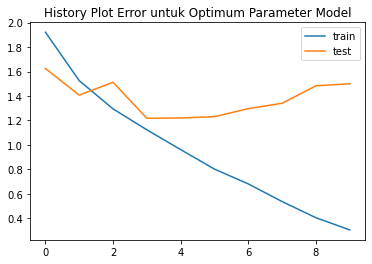

In [82]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('History Plot Error untuk Optimum Parameter Model')
plt.legend()
plt.show()

#### 6.
Gunakan _pre-trained_ model yg telah dibuat tersebut untuk diimplementasikan pada dataset $\text{CIFAR 100}$ untuk kelas $1$ hingga kelas $10$ (masing-masing kelas terdiri dari
$100$ citra) dengan rasio _data train_ dan _data test_ sebanyak $60\% : 40\%$. Kemudian hitung matrik evaluasi ($\text{accuration}$, $\text{sensitivity}$, $\text{specifity}$, dan $f_{1}\text{ score}$) dari _data train_ dan _data test_.

##### Load Data CIFAR 100

In [59]:
x_100, y_100 = load_dataset_cifar100()
x_100.shape

169009152/169001437 [==============================] - 4s 0us/step


(60000, 32, 32, 3)

##### Mengambil Dataset Sebanyak 100 Per Kelasnya

In [60]:
idx_sample_100 = np.array([],dtype=int)

for i in range(10):
    idx = (y == i).reshape(x.shape[0])
    idx_data = np.where(idx == True)
    sampled_list = np.random.choice(idx_data[0], size=100, replace=False)
    idx_sample_100 = np.concatenate((idx_sample_100, sampled_list), axis=0)

##### Melakukan Validasi Apakah Shape-nya Sudah Valid atau Belum

In [61]:
x_sample_100 = x[idx_sample_100]
y_sample_100 = y[idx_sample_100]
x_sample_100.shape, y_sample_100.shape

((1000, 32, 32, 3), (1000, 1))

##### Melakukan Normalisasi untuk $x$

In [62]:
x_sample_100 = normalize(x_sample_100)

##### Merubah Menjadi Matrix Binary untuk $y$

In [63]:
y_sample_100 = tf.keras.utils.to_categorical(y_sample_100)

##### Memecah Menjadi 60 : 40 ~ Train : Test

In [65]:
x_train_100, x_test_100, y_train_100, y_test_100 = train_test_split(x_sample_100, y_sample_100, test_size=0.4)

##### Melakukan Evaluasi Pre-Trained Model dari Train Sebelumnya

In [78]:
pre_trained_model = load_model('checkpoint_model.h5', compile=True, custom_objects={
    "recall": recall,
    "specificity": specificity,
    "f1_score": f1_score
})
compare_train_and_test(pre_trained_model, x_train_100, y_train_100, x_test_100, y_test_100)

,Accuracy,Sensitivity,Specificity,F1 Score
Data Train,0.611667,0.554825,0.969359,0.605818
Data Test,0.637500,0.591346,0.972222,0.640660


#### 7.
Buat arsitektur $\text{Convolutional Neural Network}$ yang baru dengan menggunakan semua _hidden layer pre-trained_ dari model sebelumnya, lakukan _freezing_ pada semua _hidden layer_ tersebut, lalu ganti _layer output_ $\text{softmax}$ dengan layer baru.

In [92]:
## Fungsi untuk melakukan freeze pada layer
def make_freeze(layer):
    layer.trainable = False
    return layer

## Melakukan copy untuk semua layer
copy_layers = [make_freeze(layer) for layer in pre_trained_model.layers]

## Me-replace ouput layer dengan layer baru yang trainable
copy_layers[-1] = Dense(10, activation=tf.nn.softmax)

## Membangun Model
new_cnn_model = create_model(0.001, copy_layers)

#### 8.
Implementasikan model poin $(7)$ pada dataset $\text{CIFAR 100}$ untuk kelas $1$ hingga kelas $10$ dengan rasio _data train_ dan _data test_ sebanyak $60\% : 40\%$. Kemudian hitung matrik evaluasi ($\text{accuration}$, $\text{sensitivity}$, $\text{specificity}$, dan $f_{1}\text{ score}$) dari _data train_ dan _data test_.

##### Melakukan Train pada Model CNN Baru

In [93]:
checkpoint = ModelCheckpoint("checkpoint_new_cnn_model.h5", monitor='loss', verbose=1, mode='auto', period=1)
new_cnn_model_history = new_cnn_model.fit(x_train_100, y_train_100, epochs=10, batch_size=25, validation_data=(x_test_100, y_test_100), use_multiprocessing=True, callbacks=[es, checkpoint])

Epoch 1/10
23/24 [===========================>..] - ETA: 0s - loss: 4.0587 - accuracy: 0.0626 - recall: 0.0261 - specificity: 0.9358 - f1_score: 0.0325
Epoch 00001: saving model to checkpoint_new_cnn_model.h5
24/24 [==============================] - 1s 37ms/step - loss: 4.0264 - accuracy: 0.0717 - recall: 0.0300 - specificity: 0.9376 - f1_score: 0.0388 - val_loss: 3.4928 - val_accuracy: 0.0750 - val_recall: 0.0175 - val_specificity: 0.9536 - val_f1_score: 0.0239
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 3.0061 - accuracy: 0.1350 - recall: 0.0417 - specificity: 0.9680 - f1_score: 0.0628
Epoch 00002: saving model to checkpoint_new_cnn_model.h5
24/24 [==============================] - 1s 27ms/step - loss: 3.0061 - accuracy: 0.1350 - recall: 0.0417 - specificity: 0.9680 - f1_score: 0.0628 - val_loss: 2.8454 - val_accuracy: 0.1700 - val_recall: 0.0350 - val_specificity: 0.9736 - val_f1_score: 0.0543
Epoch 3/10
22/24 [==========================>...] - ETA: 0s - loss

##### Menghitung Matrik Evaluasi Model CNN Baru

In [94]:
compare_train_and_test(new_cnn_model, x_train_100, y_train_100, x_test_100, y_test_100)

,Accuracy,Sensitivity,Specificity,F1 Score
Data Train,0.5300,0.266996,0.985563,0.378527
Data Test,0.4775,0.274038,0.987179,0.391276


#### 9.
Lalu lakukan _unfreeze_ pada satu _hidden layer_ ($\text{conv-pool-actv}$) paling atas dan lakukan kembali proses training menggunakan deskripsi data yang sama dengan poin $(8)$. Bagaimana hasil yang diperoleh dari perubahan ini?